In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
import explainabilityModels

In [2]:
#hyperparameters and blank image and label generation
N = 6000
size = 64
big_blob_size = 8
big_blob_range = 2
labels = np.random.randint(3, size = N)
imgs = np.zeros((size, size, N))


In [3]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_new_blob_img(ellipse=True, size=size,num_big_blobs=4)
    elif labels[i] == 1:
        x = generator.generate_new_blob_img(ellipse = False, size = size, num_big_blobs=4)
    elif labels[i] == 2:
        x = generator.generate_new_blob_img(ellipse= False, size = size, num_big_blobs=0)
    imgs[:,:,i] = x

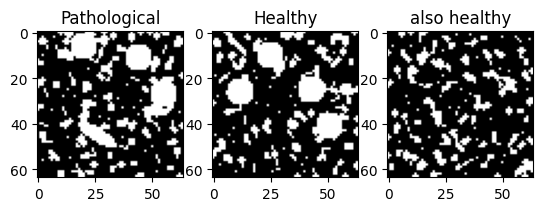

In [4]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,3)

path_img = imgs[:,:,np.where(labels == 0)[0][0]]
healthy_img = imgs[:,:,np.where(labels ==1)[0][0]]
healthy2_img = imgs[:,:,np.where(labels ==2)[0][0]]

ax[0].imshow(path_img, cmap=plt.cm.gray)
ax[1].imshow(healthy_img, cmap=plt.cm.gray)
ax[2].imshow(healthy2_img, cmap = plt.cm.gray)

ax[0].set_title("Pathological");
ax[1].set_title("Healthy");
ax[2].set_title('also healthy');

In [4]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(imgs, -1)
X = np.transpose(X, (2,1,0,3))
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(6000, 64, 64, 1)

In [5]:
# Model hyperparameters
num_classes = 3
input_shape = (size, size, 1)
batch_size = 64
epochs = 40
conv_size=(3,3)
save = True
# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [16]:
#create model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.GlobalAveragePooling2D(),
        # layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                        

In [17]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/40
57/57 [==============================] - 2s 20ms/step - loss: 0.6159 - accuracy: 0.6946 - val_loss: 1.6764 - val_accuracy: 0.3358
Epoch 2/40
57/57 [==============================] - 1s 14ms/step - loss: 0.3676 - accuracy: 0.8275 - val_loss: 4.0423 - val_accuracy: 0.3358
Epoch 3/40
57/57 [==============================] - 1s 14ms/step - loss: 0.2089 - accuracy: 0.9428 - val_loss: 4.5759 - val_accuracy: 0.3358
Epoch 4/40
57/57 [==============================] - 1s 14ms/step - loss: 0.1156 - accuracy: 0.9809 - val_loss: 3.7697 - val_accuracy: 0.3358
Epoch 5/40
57/57 [==============================] - 1s 14ms/step - loss: 0.0651 - accuracy: 0.9934 - val_loss: 1.8749 - val_accuracy: 0.3358
Epoch 6/40
57/57 [==============================] - 1s 15ms/step - loss: 0.0394 - accuracy: 0.9978 - val_loss: 0.5772 - val_accuracy: 0.7214
Epoch 7/40
57/57 [==============================] - 1s 15ms/step - loss: 0.0304 - accuracy: 0.9986 - val_loss: 0.1407 - val_accuracy: 0.9751
Epoch 8/40
57

In [9]:
if save:
    model.save("models/model40_padding")

INFO:tensorflow:Assets written to: models/model40_padding/assets


INFO:tensorflow:Assets written to: models/model40_padding/assets


In [26]:
model = tf.keras.models.load_model("models/model40_padding")

In [27]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['Pathological', 'Healthy', 'also healthy']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.04567905142903328
Test accuracy: 0.9898989796638489
62/62 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

Pathological       1.00      0.97      0.98       646
     Healthy       0.97      1.00      0.98       636
also healthy       1.00      1.00      1.00       698

    accuracy                           0.99      1980
   macro avg       0.99      0.99      0.99      1980
weighted avg       0.99      0.99      0.99      1980



In [28]:
import ipywidgets as widgets
#get array or predictions for test set

predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)


label_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1), ('also healthy', 2)],
    value=0,
    description='True Label:',
)
pred_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1), ('also healthy', 2)],
    value=0,
    description='Predicted Label:',
)
#pick what you want to see
display(label_picker)
display(pred_picker)


62/62 [==============================] - 0s 3ms/step


Dropdown(description='True Label:', options=(('Pathological', 0), ('Healthy', 1), ('also healthy', 2)), value=…

Dropdown(description='Predicted Label:', options=(('Pathological', 0), ('Healthy', 1), ('also healthy', 2)), v…

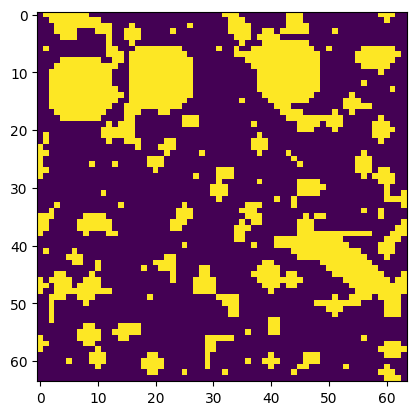

In [29]:
#show image
img = X_test[np.where((y_test == label_picker.value) & (predicted_classes == pred_picker.value))[0][0]]
plt.imshow(img)

In [30]:
heatmap = explainabilityModels.make_gradcam_heatmap(img, model)

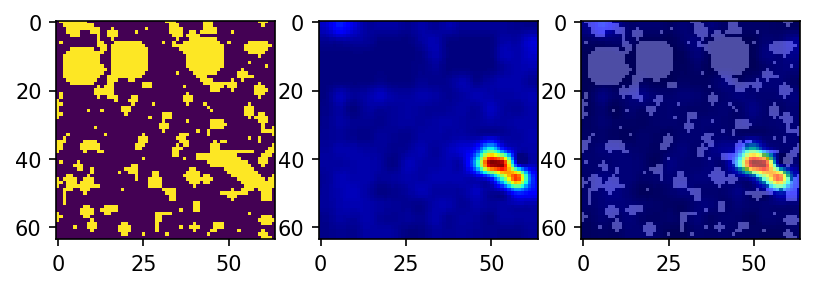

In [31]:
fig, ax = plt.subplots(1,3)
fig.set_dpi(150)
fig.tight_layout

ax[0].imshow(img)
ax[1].imshow(heatmap, cmap = 'jet')
ax[2].imshow(img, cmap = 'gray')
ax[2].imshow(heatmap, alpha = 0.7, cmap='jet')


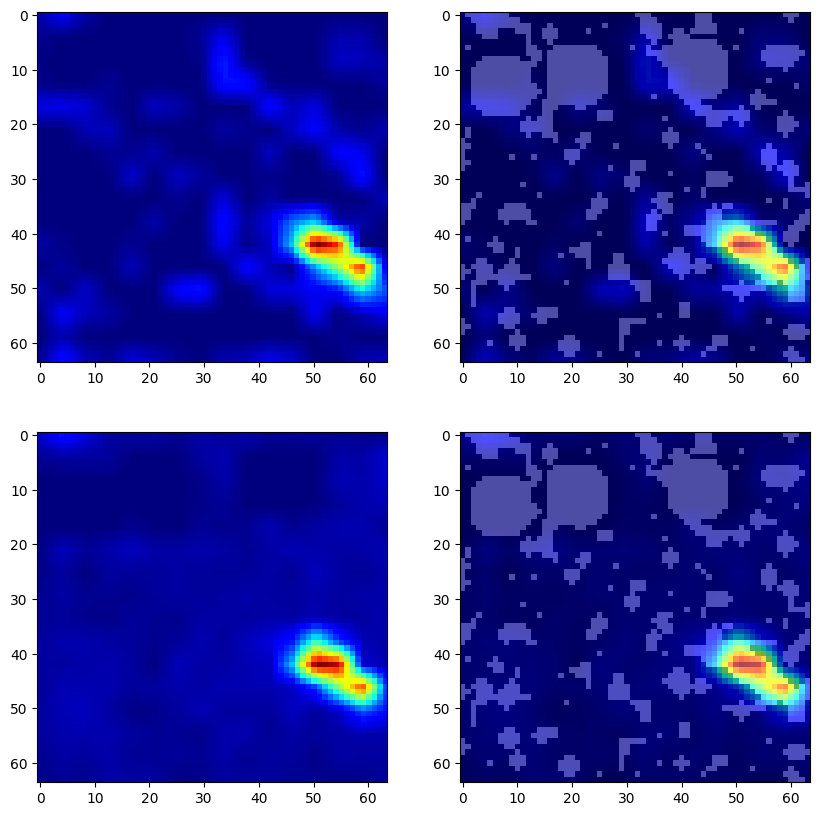

In [32]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), 
            clone=True)
gradcam2 = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)
cam = gradcam(CategoricalScore(0), img).squeeze()
cam2 = gradcam2(CategoricalScore(0), img).squeeze()

fig, ax = plt.subplots(2,2)
fig.set_size_inches((10,10))
ax[0][0].imshow(cam, cmap = 'jet')
ax[0][1].imshow(img, cmap = 'gray')
ax[0][1].imshow(cam, cmap = 'jet', alpha = 0.7)

ax[1][0].imshow(cam2, cmap = 'jet')
ax[1][1].imshow(img, cmap = 'gray')
ax[1][1].imshow(cam2, cmap = 'jet', alpha = 0.7)


4/4 [==============================] - 0s 3ms/step


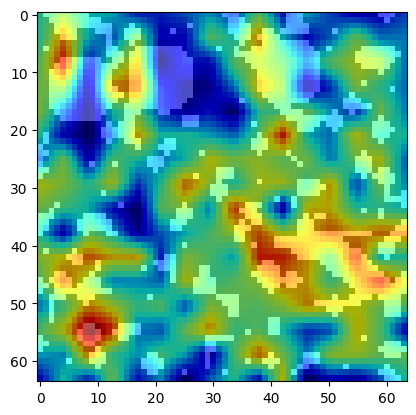

In [33]:
from tf_keras_vis.scorecam import Scorecam

scoreCam = Scorecam(model)

sC = scoreCam(CategoricalScore(0), img).squeeze()

plt.imshow(img, cmap = 'gray')
plt.imshow(sC, cmap = 'jet', alpha = 0.7)

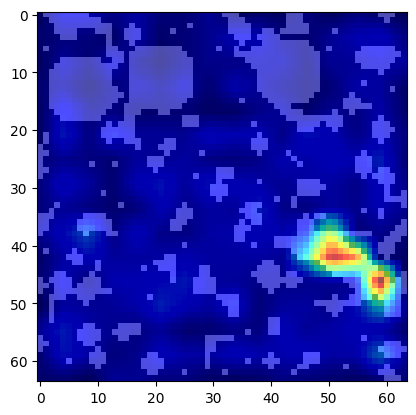

In [34]:
from tf_keras_vis.layercam import Layercam

lC = Layercam(model, model_modifier=ReplaceToLinear(), clone=True)
lC_img = lC(CategoricalScore(0), img).squeeze()

plt.imshow(img, cmap='gray')
plt.imshow(lC_img, cmap ='jet', alpha = 0.7)